<a href="https://colab.research.google.com/github/AykanIpek/Severity-Assessment/blob/main/Inflammation_Severity_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix,balanced_accuracy_score
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from collections import Counter
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

**Exploratory Data Analysis (EDA)**

In [5]:
data = pd.read_excel('/content/drive/MyDrive/Data/CSI_7_MAL_2526_Data.xlsx')
data.head()

,PatID,Severity Score,NeutroRegionA_CALC,NeutroRegionC_CALC,NeutroRegionD_CALC,NeutroRegionE_CALC,neutro_perneutro_1_CALC,neutro_pereosino_1_CALC,neutro_perepith_1_CALC,neutro_perother_1_CALC,...,NERRegionF+RegionE_CALC,NERRegionB+RegionE_CALC,NERTotal_CALC,NLRRegionA_CALC,NLRRegionC_CALC,NLRRegionB_CALC,NLRRegionE_CALC,NLRRegionF+RegionE_CALC,NLRRegionB+RegionE_CALC,NLRTotal_CALC
0,ID_001,3.0,183.0,13.0,38.0,1.0,14.855319,7.965174,8.083116,6.244365,...,26.000000,19.500000,1.169154,0.012237,0.029545,0.175926,0.166667,0.078550,0.175676,0.015048
1,ID_002,5.0,1617.0,28.0,4.0,0.0,98.713159,32.372671,8.176349,51.465719,...,4.571429,1.000000,3.414079,0.076421,0.161850,0.078431,0.000000,0.142857,0.078431,0.077117
2,ID_003,3.0,268.0,8.0,65.0,0.0,17.038123,9.425455,6.357759,6.215071,...,6.083333,5.416667,1.240000,0.011443,0.025397,0.055603,0.000000,0.049059,0.055413,0.013690
3,ID_004,4.0,295.0,5.0,56.0,2.0,25.044693,11.019324,6.698129,7.512135,...,2.520000,4.142857,0.864734,0.016013,0.009747,0.061135,0.142857,0.043659,0.062366,0.018021
4,ID_005,5.0,200.0,2.0,16.0,12.0,10.243478,5.881563,4.202329,3.699312,...,3.333333,9.333333,0.280830,0.009029,0.018182,0.181818,0.500000,0.135135,0.250000,0.010280


In [6]:
data.shape

(318, 143)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Columns: 143 entries, PatID to NLRTotal_CALC
dtypes: float64(142), object(1)
memory usage: 355.4+ KB


In [ ]:
data.describe()

,Severity Score,NeutroRegionA_CALC,NeutroRegionC_CALC,NeutroRegionD_CALC,NeutroRegionE_CALC,neutro_perneutro_1_CALC,neutro_pereosino_1_CALC,neutro_perepith_1_CALC,neutro_perother_1_CALC,eosino_perneutro_1_CALC,...,NERRegionF+RegionE_CALC,NERRegionB+RegionE_CALC,NERTotal_CALC,NLRRegionA_CALC,NLRRegionC_CALC,NLRRegionB_CALC,NLRRegionE_CALC,NLRRegionF+RegionE_CALC,NLRRegionB+RegionE_CALC,NLRTotal_CALC
count,306.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,3.030000e+02,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,2.787582,296.402640,24.339934,24.762376,1.247525,12.085625,5.333182,3.858714e+00,5.405453,8.245394,...,4.703285,4.215748,0.858177,0.011044,0.040017,0.040432,0.152947,0.041495,0.042425,0.012315
std,1.972926,516.171704,43.432828,46.555418,3.248247,19.975374,7.212174,5.032955e+00,8.281854,6.040906,...,8.137119,6.588784,1.501384,0.015832,0.045078,0.059592,0.382866,0.049152,0.061149,0.016606
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.166667,0.160714,1.410000e-16,0.223866,0.250000,...,0.000000,0.000000,0.034081,0.000604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000899
25%,0.000000,42.500000,3.500000,3.000000,0.000000,2.566700,0.771812,7.778973e-01,1.002255,3.982143,...,1.000000,0.800000,0.162546,0.002805,0.012989,0.008311,0.000000,0.012072,0.008859,0.003170
50%,3.000000,100.000000,9.000000,9.000000,0.000000,4.766667,2.330159,1.853906e+00,2.262438,6.850575,...,2.500000,2.000000,0.355932,0.005145,0.025806,0.020101,0.000000,0.022727,0.020921,0.005989
75%,5.000000,322.000000,22.500000,26.500000,1.000000,14.020707,7.110143,4.884744e+00,6.229718,11.209500,...,4.967742,5.000000,0.840759,0.012542,0.048299,0.045864,0.076923,0.050124,0.049695,0.014302
max,5.000000,3869.000000,301.000000,371.000000,23.000000,178.077402,41.184000,3.495844e+01,57.139291,38.811594,...,71.250000,52.000000,14.189300,0.103292,0.378238,0.425459,3.000000,0.352518,0.419426,0.102155


In [ ]:
data.dtypes

,0
PatID,object
Severity Score,float64
NeutroRegionA_CALC,float64
NeutroRegionC_CALC,float64
NeutroRegionD_CALC,float64
...,...
NLRRegionB_CALC,float64
NLRRegionE_CALC,float64
NLRRegionF+RegionE_CALC,float64
NLRRegionB+RegionE_CALC,float64


In [ ]:
obj_col = [x for x in data.columns if data[x].dtypes=="object"]
print(obj_col)

['PatID']


In [ ]:
diff_col = [x for x in data.columns if data[x].dtypes!="float64"]
print(diff_col)

['PatID']


In [ ]:
missing_summary = pd.DataFrame({
    'Nan count': data.isnull().sum(),
    'Filled count': data.notnull().sum(),
    'Total': len(data)
})
missing_summary

,Nan count,Filled count,Total
PatID,0,318,318
Severity Score,12,306,318
NeutroRegionA_CALC,15,303,318
NeutroRegionC_CALC,15,303,318
NeutroRegionD_CALC,15,303,318
...,...,...,...
NLRRegionB_CALC,15,303,318
NLRRegionE_CALC,15,303,318
NLRRegionF+RegionE_CALC,15,303,318
NLRRegionB+RegionE_CALC,15,303,318


/tmp/ipython-input-542914371.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='Severity Score', palette="rocket", edgecolor='black')


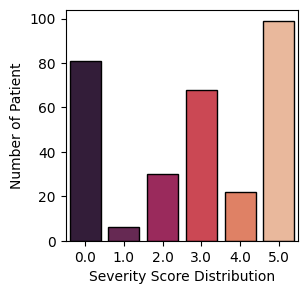

In [7]:
plt.figure(figsize=(3,3))
sns.countplot(data=data,x='Severity Score', palette="rocket", edgecolor='black')
plt.ylabel('Number of Patient')
plt.xlabel('Severity Score Distribution')
plt.show()

In [8]:
#Targets
data = data.dropna(subset=['Severity Score'])

data = data.reset_index(drop=True)

y_multi = data['Severity Score'].astype(int)
y_bin = (data['Severity Score']>= 3).astype(int)

x = data.drop(columns=['PatID','Severity Score'])
groups = data['PatID'].values

**Task 1 (Evalutaing the classification with all features)**

In [19]:
#For Multi-classification
models = dict({
    'LogisticRegression': LogisticRegression(max_iter=1000,solver='lbfgs',C=5.0,n_jobs=-1,class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(max_depth=10,random_state=42,class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=250,max_features=5,random_state=42,n_jobs=-1,class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=140,learning_rate=0.1,random_state=42,tree_method='hist',device='cuda',n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=6,weights='distance',n_jobs=-1),
    'Adaboost': AdaBoostClassifier(n_estimators=400,learning_rate=0.1,random_state=42)
})

In [24]:
#For Binary classification
counter = Counter(y_bin)
neg = counter[0]
pos = counter[1]
scale_pos_weight = neg / pos


models2 = dict({
    'LogisticRegression': LogisticRegression(max_iter=1000,solver='lbfgs',C=5.0,n_jobs=-1,class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(max_depth=10,random_state=42,class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=250,max_features=5,random_state=42,n_jobs=-1,class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=140,learning_rate=0.1,random_state=42,tree_method='hist',device='cuda',n_jobs=-1,scale_pos_weight=scale_pos_weight),
    'KNN': KNeighborsClassifier(n_neighbors=6,weights='distance',n_jobs=-1),
    'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,class_weight='balanced'),learning_rate=0.1,random_state=42)
})

In [22]:
#Multi-classification
warnings.filterwarnings('ignore')
severity_results = {}
gkf = GroupKFold(n_splits=5)

for name,model in models.items():
  acc=[]

  for train_idx, test_idx in gkf.split(x,y_multi,groups):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y_multi.iloc[train_idx], y_multi.iloc[test_idx]

    pipeline_obj = Pipeline(steps=[
        ('imputer',KNNImputer(n_neighbors=5)),
        ('scaler',StandardScaler()),
        ('model',model)
    ])

    pipeline_obj.fit(x_train,y_train)
    pred = pipeline_obj.predict(x_test)

    acc.append(accuracy_score(pred,y_test))

    severity_results[name] = {
        'mean_accuracy': np.mean(acc),
        'std_accuracy': np.std(acc)
    }
severity_score = pd.DataFrame( severity_results).T
severity_score

,mean_accuracy,std_accuracy
LogisticRegression,0.509730,0.022129
DecisionTree,0.500370,0.095710
RandomForest,0.686515,0.052461
XGBoost,0.666843,0.057975
KNN,0.536013,0.034261
Adaboost,0.608038,0.043093


In [26]:
#Binary classification
warnings.filterwarnings('ignore')
binary_results = {}
for name,model in models2.items():

  acc_scores = []
  sens_scores = []
  spec_scores = []
  auc_scores = []

  for train_idx,test_idx in gkf.split(x,y_bin,groups):
    x_train2, x_test2 = x.iloc[train_idx], x.iloc[test_idx]
    y_train2, y_test2 = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

    pipeline_obj2 = Pipeline(steps=[

        ('imputer',KNNImputer(n_neighbors=3)),
        ('scaler',StandardScaler()),
        ('model',model)
    ])
    pipeline_obj2.fit(x_train2,y_train2)
    pred2 = pipeline_obj2.predict(x_test2 )


    if hasattr(model, "predict_proba"):
      probs = pipeline_obj2.predict_proba(x_test2)[:, 1]
      auc_scores.append(roc_auc_score(y_test2, probs))

        # Metrikleri hesapla ve listelere ekle
    acc_scores.append(accuracy_score(y_test2, pred2))

        # Sensitivity (Recall)
    sens_scores.append(recall_score(y_test2, pred2))

        # Specificity hesaplama
    tn, fp, fn, tp = confusion_matrix(y_test2, pred2).ravel()
    spec_scores.append(tn / (tn + fp))


    binary_results[name] = {
        "accuracy_mean": np.mean(acc_scores),
        "sensitivity_mean": np.mean(sens_scores),
        "specificity_mean": np.mean(spec_scores),
        "roc_auc_mean": np.mean(auc_scores)
    }

binary_results = pd.DataFrame(binary_results).T
binary_results

,accuracy_mean,sensitivity_mean,specificity_mean,roc_auc_mean
LogisticRegression,0.865997,0.862520,0.868828,0.916787
DecisionTree,0.912004,0.940799,0.860227,0.900513
RandomForest,0.921682,0.924810,0.910520,0.976953
XGBoost,0.928292,0.935366,0.916183,0.971367
KNN,0.797197,0.752263,0.867905,0.897483
Adaboost,0.912004,0.914377,0.908491,0.968390


**Task 2 (Evalutaing the classification with 10 features)**

In [10]:
#For Multi-classification (Feature Selection)
selector_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=42)

selection_pipeline = Pipeline(steps=[
    ('imputer',KNNImputer(n_neighbors=3)),
    ('scale',StandardScaler()),
    ('sfs',SequentialFeatureSelector(selector_model, n_features_to_select=10, direction='forward', cv=3, n_jobs=-1))
])

selection_pipeline.fit(x,y_multi)
selected_mask = selection_pipeline.named_steps['sfs'].get_support()
best_10_features = x.columns[selected_mask].tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

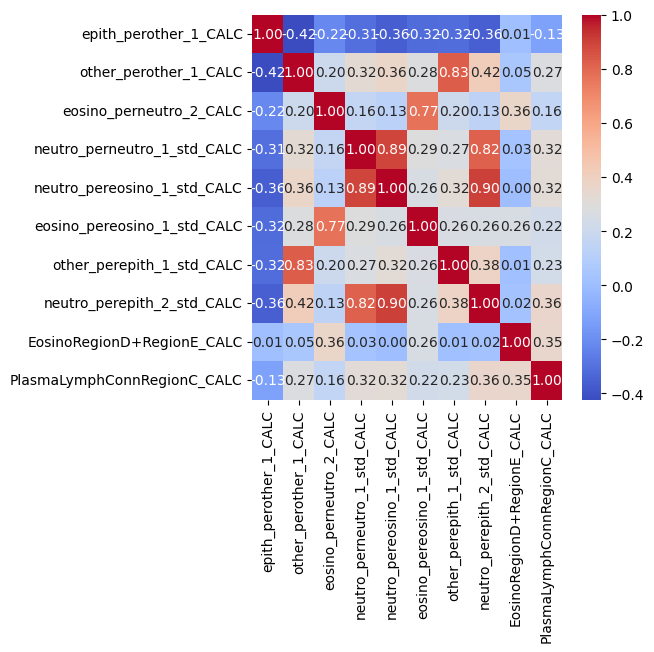

In [ ]:
corr = x[best_10_features].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
plt.show

In [ ]:
x_selected =x[best_10_features]
severity_results = {}
gkf = GroupKFold(n_splits=5)

for name,model in models.items():
  acc=[]

  for train_idx, test_idx in gkf.split(x_selected,y_multi,groups):
    x_train, x_test = x_selected.iloc[train_idx], x_selected.iloc[test_idx]
    y_train, y_test = y_multi.iloc[train_idx], y_multi.iloc[test_idx]

    pipeline_obj = Pipeline(steps=[
        ('imputer',KNNImputer(n_neighbors=5)),
        ('scaler',StandardScaler()),

        ('model',model)
    ])

    pipeline_obj.fit(x_train,y_train)
    pred = pipeline_obj.predict(x_test)

    acc.append(accuracy_score(pred,y_test))

    severity_results[name] = {
        'mean_accuracy': np.mean(acc),
        'std_accuracy': np.std(acc)
    }
severity_score = pd.DataFrame( severity_results).T
severity_score


,mean_accuracy,std_accuracy
LogisticRegression,0.539503,0.060757
DecisionTree,0.588472,0.052018
RandomForest,0.706187,0.053612
XGBoost,0.673559,0.078980
KNN,0.591698,0.043020
Adaboost,0.627552,0.060080


In [ ]:
#For binary classification (Feature Selection)
selector_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=42)

selection_pipeline2 = Pipeline(steps=[
    ('imputer',KNNImputer(n_neighbors=3)),
    ('scaler',StandardScaler()),
    ('sfs',SequentialFeatureSelector(selector_model, n_features_to_select=10, direction='forward', cv=3, n_jobs=-1))
])

selection_pipeline2.fit(x,y_bin)
selected_mask2 = selection_pipeline2.named_steps['sfs'].get_support()
best_10_features2 = x.columns[selected_mask2].tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

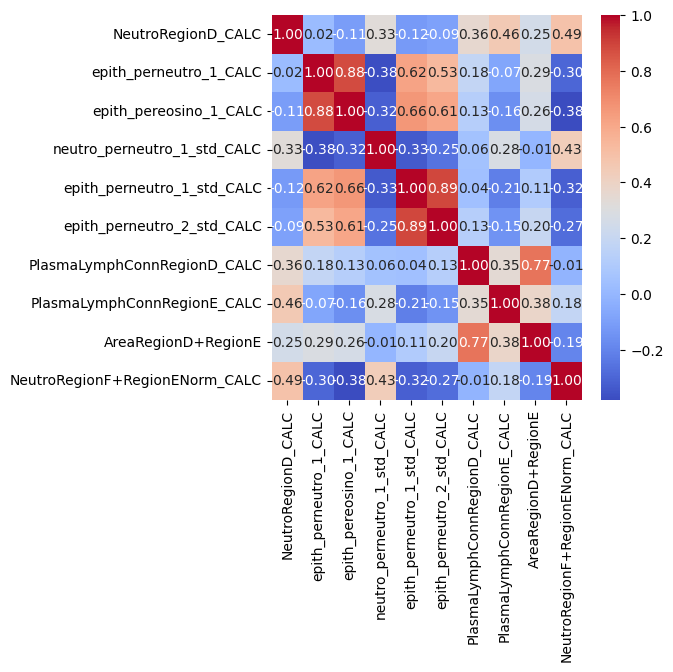

In [ ]:
corr = x[best_10_features2].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
plt.show

In [ ]:
x_selected2 = x[best_10_features2]
binary_results = {}
for name,model in models2.items():

  acc_scores = []
  sens_scores = []
  spec_scores = []
  auc_scores = []

  for train_idx,test_idx in gkf.split(x_selected2,y_bin,groups):
    x_train2, x_test2 = x_selected2.iloc[train_idx], x_selected2.iloc[test_idx]
    y_train2, y_test2 = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

    pipeline_obj2 = Pipeline(steps=[

        ('imputer',KNNImputer(n_neighbors=3)),
        ('scaler',StandardScaler()),
        ('model',model)
    ])
    pipeline_obj2.fit(x_train2,y_train2)
    pred2 = pipeline_obj2.predict(x_test2 )


    if hasattr(model, "predict_proba"):
      probs = pipeline_obj2.predict_proba(x_test2)[:, 1]
      auc_scores.append(roc_auc_score(y_test2, probs))

        # Metrikleri hesapla ve listelere ekle
    acc_scores.append(accuracy_score(y_test2, pred2))

        # Sensitivity (Recall)
    sens_scores.append(recall_score(y_test2, pred2))

        # Specificity hesaplama
    tn, fp, fn, tp = confusion_matrix(y_test2, pred2).ravel()
    spec_scores.append(tn / (tn + fp))


    binary_results[name] = {
        "accuracy_mean": np.mean(acc_scores),
        "sensitivity_mean": np.mean(sens_scores),
        "specificity_mean": np.mean(spec_scores),
        "roc_auc_mean": np.mean(auc_scores)
    }

binary_results = pd.DataFrame(binary_results).T
binary_results



,accuracy_mean,sensitivity_mean,specificity_mean,roc_auc_mean
LogisticRegression,0.862771,0.825976,0.924044,0.947544
DecisionTree,0.908567,0.919255,0.885165,0.902210
RandomForest,0.931412,0.945678,0.902689,0.968930
XGBoost,0.937969,0.930244,0.947260,0.957256
KNN,0.718826,0.711640,0.727348,0.809126
Adaboost,0.898784,0.861287,0.957260,0.968175


In [ ]:
#Hyperparameter adjustment
x_selected2 = x[best_10_features2]
model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
   'model__n_estimators': [200,250,300],
   'model__max_depth': [5,7,10],
   'model__min_samples_split': [5,10,20]
}

pipeline_grid = Pipeline(steps=[
    ('imputer',KNNImputer(n_neighbors=3)),
    ('scale',StandardScaler()),
    ('model',model)
])

gkf2 = GroupKFold(n_splits=5)
outer_results = []
for train_idx,test_idx in gkf2.split(x_selected2,y_bin,groups):
  x_train3,x_test3 = x_selected2.iloc[train_idx], x_selected2.iloc[test_idx]
  y_train3,y_test3 = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

  halving_search = HalvingRandomSearchCV(pipeline_grid,
                        param_grid,
                        factor=3,
                        cv=3,
                        scoring='balanced_accuracy',
                        n_jobs=-1,
                        random_state=42,
                        refit=True
    )

  halving_search.fit(x_train3,y_train3)
  best_model = halving_search.best_estimator_

  y_pred = best_model.predict(x_test3)
  y_proba = best_model.predict_proba(x_test3)[:,1]

  #Metrics
  bal_acc = balanced_accuracy_score(y_test3,y_pred)
  tn,fp,fn,tp = confusion_matrix(y_test3,y_pred).ravel()
  sensitivity = recall_score(y_test3,y_pred)
  specificity  = tn/(tn+fp)
  roc_auc = roc_auc_score(y_test3,y_pred)
  acc_mean = accuracy_score(y_test3,y_pred)


  outer_results.append({
        'best_model': best_model,
        'halving_search': halving_search,
        'y_test': y_test3,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'balanced_accuracy': bal_acc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'acc_mean': np.mean(acc_mean)
    })

results_df = pd.DataFrame(outer_results)
best_idx = results_df['acc_mean'].idxmax()
best_result = results_df.loc[best_idx]
best_model = best_result['best_model']


print(f"Accuracy            : {best_result['acc_mean']:.4f}")
print(f"Balanced Accuracy   : {best_result['balanced_accuracy']:.4f}")
print(f"Sensitivity (Recall): {best_result['sensitivity']:.4f}")
print(f"Specificity         : {best_result['specificity']:.4f}")
print(f"ROC-AUC             : {best_result['roc_auc']:.4f}")


Accuracy            : 0.9836
Balanced Accuracy   : 0.9861
Sensitivity (Recall): 0.9722
Specificity         : 1.0000
ROC-AUC             : 0.9861


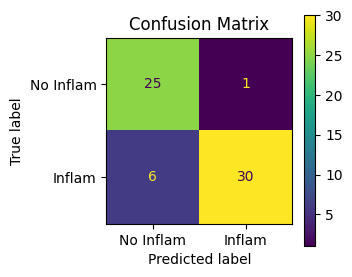

In [ ]:
last = outer_results[-1]
fig, ax = plt.subplots(figsize=(3,3))
disp = ConfusionMatrixDisplay.from_predictions(
    last['y_test'],
    last['y_pred'],
    display_labels=['No Inflam', 'Inflam'],
    ax=ax
)
plt.title("Confusion Matrix")
plt.show()

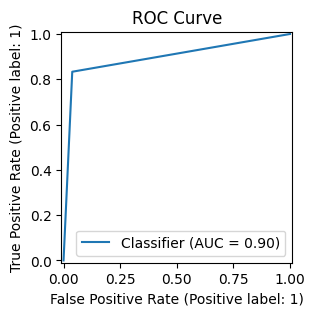

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
RocCurveDisplay.from_predictions(last['y_test'],last['y_pred'],ax=ax)
plt.title("ROC Curve")
plt.show()

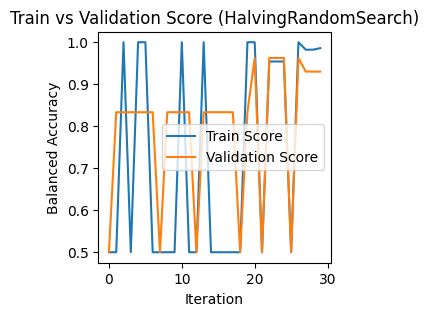

In [ ]:
cv_results = last['halving_search'].cv_results_
plt.figure(figsize=(3,3))
plt.plot(cv_results['mean_train_score'], label='Train Score')
plt.plot(cv_results['mean_test_score'], label='Validation Score')
plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.title('Train vs Validation Score (HalvingRandomSearch)')
plt.legend()
plt.show()

In [ ]:
explainer = shap.TreeExplainer(last['best_model'].named_steps['model'])
shap_values = explainer.shap_values(x_test3)

feature_names = x_test3.columns
shap_importance = np.abs(shap_values[:, :, 1]).mean(0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Score': shap_importance
}).sort_values(by='Importance_Score', ascending=False)

print(importance_df.head(10))

                          Feature  Importance_Score
3     neutro_perneutro_1_std_CALC          0.214051
9  NeutroRegionF+RegionENorm_CALC          0.108553
0              NeutroRegionD_CALC          0.057803
1          epith_perneutro_1_CALC          0.054195
7     PlasmaLymphConnRegionE_CALC          0.031312
4      epith_perneutro_1_std_CALC          0.028515
2          epith_pereosino_1_CALC          0.028317
6     PlasmaLymphConnRegionD_CALC          0.008616
8             AreaRegionD+RegionE          0.008404
5      epith_perneutro_2_std_CALC          0.006367


<Figure size 800x600 with 0 Axes>

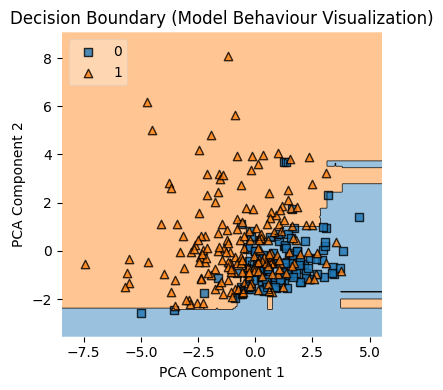

In [ ]:
X_vis = x_selected2.copy()
y_vis = y_bin.copy()

# Impute missing values before scaling and PCA
imputer = KNNImputer(n_neighbors=3) # Using n_neighbors=3 as used in selection_pipeline2
X_imputed = imputer.fit_transform(X_vis)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed) # Scale the imputed data

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

clf_vis = RandomForestClassifier(**best_model.named_steps['model'].get_params())
clf_vis.fit(X_pca, y_vis)
plt.figure(figsize=(8,6))

fig, ax = plt.subplots(figsize=(4,4))
plot_decision_regions(
    X=X_pca,
    y=y_vis.values,
    clf=clf_vis,
    legend=2,
    ax=ax
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary (Model Behaviour Visualization)")
plt.tight_layout()
plt.show()